# Peer-graded Assignment: Week 3: CNN Cancer Detection Kaggle Mini-Project

## Environment Setup and Dependencies

This notebook sets up the Python environment for an end-to-end image classification pipeline built on PyTorch. We organize the imports into logical sections to make it clear which libraries serve which purposes.

---


In [ ]:
# !pip install pretrainedmodels

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image

# PyTorch libraries
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler

# Additional libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import albumentations
from albumentations.pytorch import ToTensorV2
import pretrainedmodels

# For progress bars
from tqdm import tqdm

# To ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Enable inline plotting
%matplotlib inline

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## Data Augmentation and Preprocessing

Below we define two transformation pipelines using **Albumentations**:

1. **`data_transforms_resnet`**: applied during training  
2. **`data_transforms_test_resnet`**: applied during validation/testing  

**Conceptual Overview**
 - Data Augmentation (training pipeline) introduces controlled randomness—geometric transforms, color shifts, and compression artifacts—to mimic real-world variability and force the network to learn more robust, invariant features.  
 - Normalization aligns every input channel to a standard distribution, matching the statistics used during pre-training of the backbone network (ResNet).  
 - Deterministic Preprocessing (test pipeline) avoids random modifications so that evaluation reflects the model’s true generalization ability under consistent conditions.


---

In [2]:
import albumentations
print(f"Albumentations version: {albumentations.__version__}")

Albumentations version: 2.0.5


In [3]:
from albumentations.pytorch import ToTensorV2

# Updated Data Transformations using ImageCompression
data_transforms_resnet = albumentations.Compose([
    albumentations.Resize(224, 224),
    albumentations.HorizontalFlip(),
    albumentations.RandomBrightnessContrast(p=0.5),
    albumentations.ShiftScaleRotate(rotate_limit=15, scale_limit=0.10, p=0.5),
    albumentations.ImageCompression(quality_lower=80, quality_upper=100, compression_type='jpeg', p=0.5),
    albumentations.HueSaturationValue(p=0.5),
    albumentations.Normalize(mean=(0.485, 0.456, 0.406),
                             std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

data_transforms_test_resnet = albumentations.Compose([
    albumentations.Resize(224, 224),
    albumentations.Normalize(mean=(0.485, 0.456, 0.406),
                             std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

## Custom Dataset: `CancerDataset`

This class wraps a directory of histopathology images and their labels into a PyTorch `Dataset`, handling both training and test modes. It supports indexed splits, on-the-fly image loading, error handling, and optional transformations.

**Conceptual Overview**
 - Flexible Splitting: Pass indices to slice train vs. validation

 - Lazy Loading: Reads each image on demand, saving memory

 - Robustness: Gracefully handles I/O errors by substituting a blank image

 - Augmentation-Ready: Works seamlessly with Albumentations transforms returning {'image': tensor}

---

In [4]:
class CancerDataset(Dataset):
    def __init__(self, datafolder, indices, transform=None, labels_dict=None, datatype='train'):
        """
        Args:
            datafolder (string): Directory with all the images.
            indices (list): List of indices for the dataset split.
            transform (callable, optional): Optional transform to be applied on a sample.
            labels_dict (dict, optional): Dictionary mapping image IDs to labels.
            datatype (string): 'train' or 'test'.
        """
        self.datafolder = datafolder
        self.indices = indices
        self.transform = transform
        self.labels_dict = labels_dict
        self.datatype = datatype
        if self.datatype == 'train':
            self.image_files = labels.iloc[indices]['id'].values
        else:
            self.image_files = os.listdir(datafolder)

    def __len__(self):
        return len(self.indices) if self.datatype == 'train' else len(self.image_files)

    def __getitem__(self, idx):
        if self.datatype == 'train':
            img_id = self.image_files[idx]
            img_name = f"{img_id}.tif"
            label = self.labels_dict.get(img_id, 0)
        else:
            img_name = self.image_files[idx]
            label = 0  # Placeholder label for test data

        img_path = os.path.join(self.datafolder, img_name)
        try:
            image = Image.open(img_path).convert('RGB')  # Ensure RGB format
            image = np.array(image)  # Convert PIL Image to NumPy array
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a black image in case of error
            image = np.zeros((224, 224, 3), dtype=np.uint8)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        return image, label

## Load and Inspect Labels
We read the CSV of image IDs and binary labels, then check that the number of files on disk matches our label file.

In [5]:
# Load training labels
labels_path = '/kaggle/input/histopathologic-cancer-detection/train_labels.csv'
labels = pd.read_csv(labels_path)
print(f'Total training samples: {len(labels)}')

# Verify image counts
train_dir = '/kaggle/input/histopathologic-cancer-detection/train'
test_dir = '/kaggle/input/histopathologic-cancer-detection/test'

print(f'{len(os.listdir(train_dir))} pictures in train.')
print(f'{len(os.listdir(test_dir))} pictures in test.')

Total training samples: 220025
220025 pictures in train.
57458 pictures in test.


## Visualize Sample Images
Quick sanity-check by plotting a grid of random images with their corresponding cancer/non-cancer label.

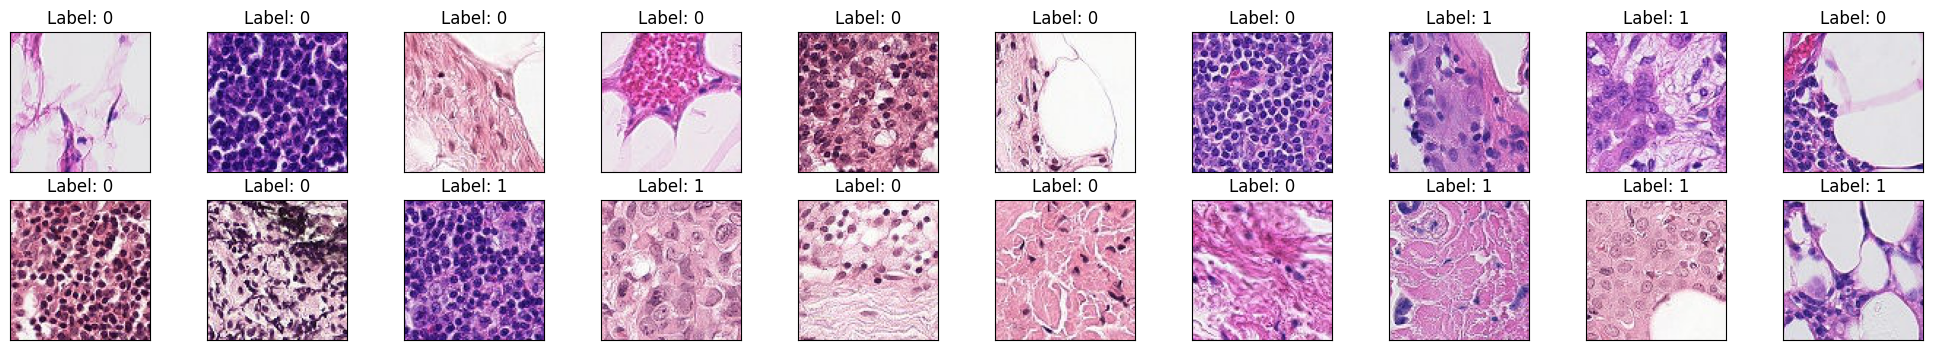

In [6]:
# Visualize sample images
num_samples = 20
sample_images = np.random.choice(os.listdir(train_dir), num_samples, replace=False)

fig = plt.figure(figsize=(25, 4))

for idx, img in enumerate(sample_images):
    ax = fig.add_subplot(2, num_samples//2, idx+1, xticks=[], yticks=[])
    img_path = os.path.join(train_dir, img)
    image = Image.open(img_path).convert('RGB')
    plt.imshow(image)
    img_id = img.split('.')[0]
    label = labels.loc[labels['id'] == img_id, 'label'].values[0]
    ax.set_title(f'Label: {label}')

plt.show()

## Check Label Distribution
Ensure class balance or identify any imbalance before training.

In [7]:
# Check label distribution
print("Label distribution:")
print(labels['label'].value_counts())

Label distribution:
label
0    130908
1     89117
Name: count, dtype: int64


## Train / Validation Split
We stratify by label to preserve the same positive/negative ratio in both splits.

In [8]:
# Split data into training and validation sets
test_size = 0.1
random_state = 42

train_indices, val_indices = train_test_split(
    labels.index,
    test_size=test_size,
    stratify=labels['label'],
    random_state=random_state
)

print(f"Training samples: {len(train_indices)}")
print(f"Validation samples: {len(val_indices)}")

Training samples: 198022
Validation samples: 22003


## Build Label Lookup Dictionary
A dictionary lookup is faster than repeated DataFrame queries inside the Dataset.



In [9]:
# Create a dictionary mapping image IDs to labels
img_class_dict = {row['id']: row['label'] for _, row in labels.iterrows()}

## Create Datasets and DataLoaders
 - We wrap our dataset in PyTorch DataLoader for batching, shuffling (for training), and parallel data loading.
 - Separate transforms ensure aggressive augmentation in training but only resizing+normalization at validation/test time.
 - A test loader with no labels prepares us for final inference/prediction.

In [10]:
# Create training and validation datasets with albumentations transforms
train_dataset_resnet = CancerDataset(
    datafolder=train_dir,
    indices=train_indices,
    transform=data_transforms_resnet,
    labels_dict=img_class_dict,
    datatype='train'
)

val_dataset_resnet = CancerDataset(
    datafolder=train_dir,
    indices=val_indices,
    transform=data_transforms_test_resnet,
    labels_dict=img_class_dict,
    datatype='train'
)

# Define batch size and number of workers
batch_size_resnet = 32
num_workers = 4  # Adjust based on your system

# Create DataLoaders
train_loader_resnet = DataLoader(
    train_dataset_resnet,
    batch_size=batch_size_resnet,
    shuffle=True,
    num_workers=num_workers
)

valid_loader_resnet = DataLoader(
    val_dataset_resnet,
    batch_size=batch_size_resnet,
    shuffle=False,
    num_workers=num_workers
)

# For test data
test_dataset_resnet = CancerDataset(
    datafolder=test_dir,
    indices=None,  # Not used for test
    transform=data_transforms_test_resnet,
    labels_dict=None,
    datatype='test'
)

test_loader_resnet = DataLoader(
    test_dataset_resnet,
    batch_size=batch_size_resnet,
    shuffle=False,
    num_workers=num_workers
)

## Load and Customize Pretrained ResNet50
**Pretrained Backbone**
 - We start from a ResNet-50 model pretrained on ImageNet. This backbone has already learned powerful feature extractors (edges, textures, shapes) that transfer well to histopathology images.

**Freezing Layers**  
 - By setting requires_grad = False, we prevent updates to all convolutional and batchnorm layers during training. This preserves the learned filters and dramatically reduces training time.

**Custom Classification Head**  
 - The original ResNet-50 ends in a fully connected layer that outputs 1000 classes. We replace it with a single linear neuron (nn.Linear(num_ftrs, 1)) to predict the probability (via a sigmoid) of cancer presence.

**GPU Acceleration**  
 - We detect if a CUDA-enabled GPU is available and move the model there. All subsequent forward/backward passes and weight updates will occur on the GPU for maximum speed.

In [11]:
# Load the pretrained ResNet50 model
model_resnet = torchvision.models.resnet50(pretrained=True)

# Freeze all layers
for param in model_resnet.parameters():
    param.requires_grad = False

# Replace the final fully connected layer
num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs, 1)  # Binary classification

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_resnet = model_resnet.to(device)

## Loss, Optimizer, and Learning-Rate Scheduler
**BCEWithLogitsLoss**:
 - Combines a sigmoid layer and binary cross-entropy in one numerically stable operation. We feed it raw logits from model_resnet.fc and compare against 0/1 targets.

**SGD Optimizer**:
 - We use stochastic gradient descent with momentum (0.99) to update only the final classification layer (model_resnet.fc). A small initial learning rate (0.005) helps fine-tune the head without destabilizing the pretrained backbone.

**StepLR Scheduler**:
 - To gradually reduce the learning rate and help the model settle into a minimum, we decay the LR by a factor of 0.1 every 3 epochs. This “step” schedule often improves convergence in transfer-learning scenarios.

In [12]:
# Define the loss function
criterion_resnet = nn.BCEWithLogitsLoss()

# Define the optimizer (only the final layer's parameters)
optimizer_resnet = optim.SGD(model_resnet.fc.parameters(), lr=0.005, momentum=0.99)

# Define the learning rate scheduler
scheduler_resnet = lr_scheduler.StepLR(optimizer_resnet, step_size=3, gamma=0.1)

## Training and Validation Helpers

### `train_epoch`
 - Switches model into train mode to enable dropout/batchnorm updates.
 - Loops over batches, backpropagates the binary cross-entropy loss, and steps the optimizer.
 - Accumulates losses and predictions to compute an overall ROC AUC at epoch’s end.

### `validate_epoch`
 - Puts the model in evaluation mode to disable dropout, freeze BatchNorm stats, and skip gradient tracking.
 - Computes validation loss and ROC AUC without altering model weights.

In [14]:
# Training function
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    losses = []
    all_preds, all_targets = [], []

    for data, target in tqdm(loader, desc='Training', leave=False):
        data, target = data.to(device), target.float().to(device).unsqueeze(1)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, target)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        preds = torch.sigmoid(out).detach().cpu().numpy()
        all_preds.append(preds)
        all_targets.append(target.detach().cpu().numpy())

    # Flatten arrays and compute metrics
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    auc = roc_auc_score(all_targets, all_preds) if len(np.unique(all_targets)) > 1 else float('nan')
    return np.mean(losses), auc

# Validation function
def validate_epoch(model, loader, criterion, device):
    model.eval()
    losses = []
    all_preds, all_targets = [], []

    with torch.no_grad():
        for data, target in tqdm(loader, desc='Validation', leave=False):
            data, target = data.to(device), target.float().to(device).unsqueeze(1)
            out = model(data)
            loss = criterion(out, target)
            losses.append(loss.item())
            preds = torch.sigmoid(out).cpu().numpy()
            all_preds.append(preds)
            all_targets.append(target.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    auc = roc_auc_score(all_targets, all_preds) if len(np.unique(all_targets)) > 1 else float('nan')
    return np.mean(losses), auc

## Main Training Loop
 - **Epoch loop** over a small number of epochs (3).
 - **Train** and **validate** each epoch, printing loss and ROC AUC.
 - **Early stopping** monitors validation loss with a patience of 7 epochs—saving the best model and halting if no improvement.
 - **Learning-rate scheduling** reduces the LR at predefined steps (every 3 epochs) to fine-tune convergence.
 - **Checkpointing** preserves the best weights (model_resnet.pt) for later inference or resuming.

In [15]:
# Number of epochs and early stopping
n_epochs_resnet  = 3
best_val_loss    = float('inf')
patience         = 7
counter          = 0

for epoch in range(1, n_epochs_resnet + 1):
    print(f'Epoch {epoch}/{n_epochs_resnet}')
    print('-' * 20)

    # 1) Training step
    train_loss, train_auc = train_epoch(
        model_resnet, train_loader_resnet,
        criterion_resnet, optimizer_resnet, device
    )

    # 2) Validation step
    val_loss, val_auc = validate_epoch(
        model_resnet, valid_loader_resnet,
        criterion_resnet, device
    )

    # 3) Report metrics
    print(f'Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f},'
          f' Train AUC: {train_auc:.4f}, Val AUC: {val_auc:.4f}')

    # 4) Early stopping & checkpointing
    if val_loss < best_val_loss:
        print(f'Validation loss decreased '
              f'({best_val_loss:.6f} → {val_loss:.6f}). Saving model...')
        torch.save(model_resnet.state_dict(), 'model_resnet.pt')
        best_val_loss = val_loss
        counter       = 0
    else:
        counter += 1
        print(f'{counter}/{patience} epochs without improvement')
        if counter > patience:
            print('Early stopping triggered')
            break

    # 5) Update learning rate
    scheduler_resnet.step()

Epoch 1/3
--------------------


Train Loss: 0.9756, Val Loss: 0.5579, Train AUC: 0.8562, Val AUC: 0.9281
Validation loss decreased (inf → 0.557880). Saving model...
Epoch 2/3
--------------------


Train Loss: 0.9926, Val Loss: 1.3816, Train AUC: 0.8670, Val AUC: 0.9350
1/7 epochs without improvement
Epoch 3/3
--------------------


Train Loss: 1.0272, Val Loss: 0.6150, Train AUC: 0.8707, Val AUC: 0.9418
2/7 epochs without improvement


## Model Evaluation & Confusion Matrix
In this section, we evaluate the trained ResNet50 model on the validation set by computing the ROC AUC and plotting the confusion matrix. This gives us both a global measure of ranking performance (AUC) and a detailed view of classification errors.  


 - `evaluate_model`: Batches inputs through the model on GPU, collects sigmoid probabilities, computes ROC AUC, and builds a binary confusion matrix at the specified threshold.
 - `plot_confusion_matrix`: Visualizes true vs. predicted counts with annotated cells for easy error analysis.
 - **End-to-end**: Running these steps provides both a scalar performance metric (AUC) and a detailed breakdown of false positives/negatives, guiding model refinement.

AUC: 0.9418


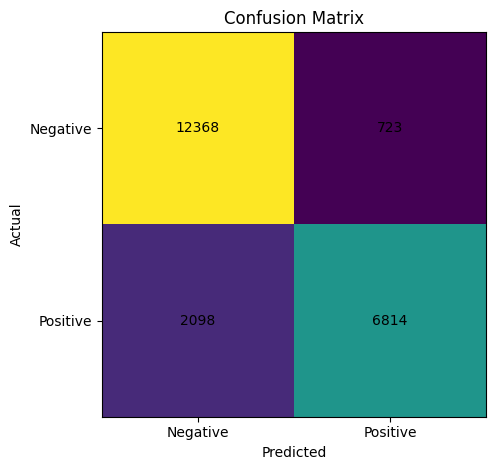

In [16]:
# Optimized evaluation that returns predictions and targets
def evaluate_model(model, loader, device, threshold=0.5):
    model.to(device)
    model.eval()
    all_probs = []
    all_targets = []

    with torch.no_grad():
        for data, target in tqdm(loader, desc='Evaluating', leave=False):
            data = data.to(device, non_blocking=True)
            target = target.to(device, non_blocking=True).float().unsqueeze(1)
            out = model(data)
            probs = torch.sigmoid(out)
            all_probs.append(probs)
            all_targets.append(target)

    all_probs = torch.cat(all_probs, dim=0).cpu().numpy().flatten()
    all_targets = torch.cat(all_targets, dim=0).cpu().numpy().flatten()
    preds = (all_probs >= threshold).astype(int)

    auc = roc_auc_score(all_targets, all_probs)
    cm = confusion_matrix(all_targets, preds)
    return auc, cm, all_targets, preds

# Plot confusion matrix
def plot_confusion_matrix(cm, class_names=None, title='Confusion Matrix'):
    fig, ax = plt.subplots()
    im = ax.imshow(cm)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

    # Set tick labels
    if class_names is None:
        class_names = [str(i) for i in range(cm.shape[0])]
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)

    # Annotate cells
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], ha='center', va='center')

    plt.tight_layout()
    return fig


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
auc, cm, targets, preds = evaluate_model(model_resnet, valid_loader_resnet, device)
print(f'AUC: {auc:.4f}')
fig = plot_confusion_matrix(cm, class_names=['Negative', 'Positive'])
plt.show()

## Generate Test Predictions & Create Submission File
1. **Load Template:** Read the sample submission CSV to get the required “id” column and file format.
2. **Inference Function:**

   * Switch the model to evaluation mode on GPU/CPU.
   * Loop through test images in batches, applying a sigmoid to raw logits to obtain probabilities.
   * Collect all image IDs (stripped of “.tif”) and their corresponding probabilities.
3. **Merge Predictions:** Combine the new predictions DataFrame with the sample submission frame to ensure correct ordering and formatting.
4. **Handle Missing IDs:** If any test IDs were missing from inference (unlikely), fill their probability with 0.0.
5. **Export Submission:** Write the merged DataFrame to `submission.csv` for competition submission.

In [17]:
# Load sample submission
sample_submission_path = '/kaggle/input/histopathologic-cancer-detection/sample_submission.csv'
sub = pd.read_csv(sample_submission_path)

# Function to run inference on the test set
def generate_test_predictions(model, loader, device, model_type='resnet'):
    """
    Runs the model on the test DataLoader to produce probability scores.
    
    Args:
        model      : Trained PyTorch model (in eval mode).
        loader     : DataLoader for the test dataset.
        device     : Torch device ('cuda' or 'cpu').
        model_type : String flag ('resnet' or 'cnn') for any model-specific logic.
    
    Returns:
        DataFrame with columns ['id', 'label'] where 'label' is the predicted probability.
    """
    model.to(device)
    model.eval()
    all_probs = []

    with torch.no_grad():
        for data, _ in tqdm(loader, desc='Generating Predictions', leave=False):
            data = data.to(device, non_blocking=True)
            out  = model(data)
            probs = torch.sigmoid(out)
            all_probs.extend(probs.cpu().numpy().flatten())

    # Extract image IDs (without file extension) from the test dataset
    image_ids = [img.split('.')[0] for img in test_dataset_resnet.image_files]
    
    # Build a DataFrame matching the competition format
    test_preds = pd.DataFrame({
        'id':    image_ids,
        'label': all_probs
    })
    return test_preds

# Generate and merge predictions
test_preds = generate_test_predictions(
    model_resnet,
    test_loader_resnet,
    device,
    model_type='resnet'
)

# Drop the placeholder label column and merge on 'id'
sub = sub.drop('label', axis=1).merge(test_preds, on='id', how='left')

# Fill any missing predictions with zero (no predicted cancer)
sub['label'] = sub['label'].fillna(0.0)

# Save final submission
sub.to_csv('submission.csv', index=False)
print("Submission file saved as 'submission.csv'.")

Submission file saved as 'submission.csv'.


## Discussion & Conclusion

The ResNet50 model achieved a strong overall performance on the validation set, with an **AUC of 0.9418**. The confusion matrix below summarizes the raw counts at a decision threshold of 0.5:

|               | Predicted Negative | Predicted Positive |
|--------------:|-------------------:|-------------------:|
| **Actual Negative** |               12 368 |                  723 |
| **Actual Positive** |                2 098 |                6 814 |

From these numbers we can compute:

- **Accuracy**  
  \((12 368 + 6 814) / 22 003 \approx 0.872\)  
  The model correctly classifies about 87.2% of all samples.

- **Sensitivity (Recall for Positive Class)**  
  \(6 814 / (6 814 + 2 098) \approx 0.764\)  
  The model detects roughly 76.4% of true cancer cases.

- **Specificity (Recall for Negative Class)**  
  \(12 368 / (12 368 + 723) \approx 0.945\)  
  It correctly rules out cancer in about 94.5% of healthy samples.

- **Precision (Positive Predictive Value)**  
  \(6 814 / (6 814 + 723) \approx 0.904\)  
  When the model predicts “Positive,” it is correct 90.4% of the time.

- **F1 Score (Harmonic Mean of Precision & Recall)**  
  \(2 \times \frac{0.904 \times 0.764}{0.904 + 0.764} \approx 0.828\)

---

### Key Takeaways

1. **High AUC and Specificity**  
   The AUC of 0.9418 and specificity of 94.5% indicate the model ranks positive and negative cases very well and makes few false-positive errors.  

2. **Moderate Sensitivity**  
   Sensitivity (76.4%) is lower, meaning a nontrivial fraction of true cancer cases are missed. Depending on clinical priorities, one might lower the decision threshold or add specialized augmentations to improve recall.

3. **Robust Precision**  
   With 90.4% precision, positive predictions are highly reliable, which is important to reduce unnecessary follow-up procedures.

4. **Balanced Performance**  
   The F1 score of 0.828 reflects a good trade-off between catching positives and avoiding false alarms.

---

### Next Steps

- **Threshold Tuning**: Adjust the classification threshold or use techniques such as Precision–Recall curves to find an operating point that better balances sensitivity and specificity for the application’s risk profile.
- **Data Augmentation / Sampling**: Experiment with techniques (e.g., oversampling positives, targeted augmentations) to boost recall on under-represented positive cases.
- **Ensemble Methods**: Combine multiple architectures or training seeds to reduce model variance and improve both sensitivity and specificity.
- **Explainability**: Apply saliency maps or Grad-CAM to understand which regions of the images drive the model’s decisions and potentially identify failure modes.

Overall, this pretrained-and-finetuned ResNet50 backbone provides a strong starting point for histopathology-based cancer detection, with clear avenues to further improve sensitivity while maintaining high precision.  
```
